In [148]:
# Question 4 Devoir 2
# Auteur : Lenny SIEMENI (1055234)

## Apercu des donnees

On a effectue quelques pre-traitement sur les donnees. Par exemple, on va utiliser un jeu de donnees dont on a decide de supprimer les valeurs inconnues dans toutes les categories sauf le pays d'origine ainsi que l'origine ethnique. Meme si le pays reste represente par un '?', n'ayant pas les connaissances en geopolitique suffisantes, on a jugee qu'il serait trop discriminatoire que de radier l'individu dont le pays est inconnu de la base de donnees. Ceci peut etre du a un pays qui n'est pas reconnu 'officiellement', mais dont le peuple existe bel et bien. Il en va de meme que pour la decision de ne pas supprimer une personne lorsque l'origine est inconnue. Ceci pourrait etre du a une mauvaise identification ou l'incapacite d'identifier l'origine ethnique de la personne (ou la personne pourrait decider de ne pas specifier son origine) lors du rescencement.

In [149]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations
import random

df = pd.read_csv("adult.csv")

### Voici un apercu des donnees

In [150]:
print("Taille:",len(df_modified),"elements")
df.head()

Taille: 45222 elements


age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

Et ci-bas une idee de la representation de plusieurs categories dans les donnees.

(array([  777.,  2825.,  2933., 24910.,  4482.,  5621.,  2541.,   648.,
          287.,   198.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

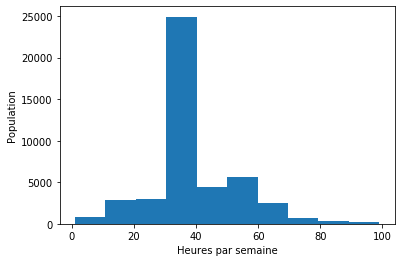

In [151]:
plt.xlabel('Heures par semaine')
plt.ylabel('Population')
plt.hist(df_modified['hours-per-week'])

In [152]:
df_modified.groupby(['workclass'])['hours-per-week'].mean()

workclass
Federal-gov         41.433144
Local-gov           40.865484
Private             40.258925
Self-emp-inc        48.578372
Self-emp-not-inc    44.429136
State-gov           39.121788
Without-pay         33.952381
Name: hours-per-week, dtype: float64

In [153]:
df_modified.groupby(['income'])['income'].count()

income
<=50K    34014
>50K     11208
Name: income, dtype: int64

In [154]:
df.groupby(['gender', 'income'])['gender'].count()

gender  income
Female  <=50K     14423
        >50K       1769
Male    <=50K     22732
        >50K       9918
Name: gender, dtype: int64

(array([ 4228.,     0., 38903.,     0.,     0.,   353.,     0.,   435.,
            0.,  1303.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

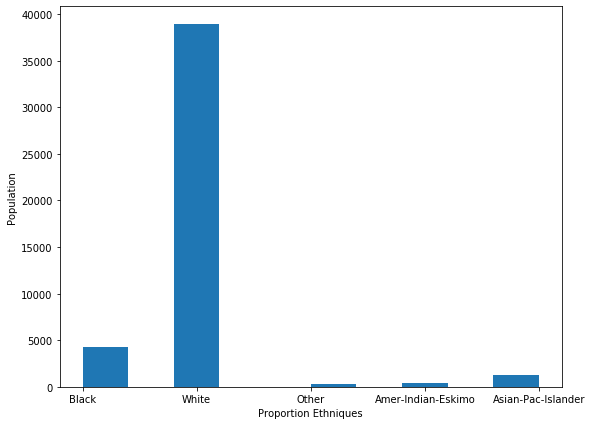

In [155]:
plt.figure(figsize=(9, 7))
plt.xlabel('Proportion Ethniques')
plt.ylabel('Population')
plt.hist(df_modified['race'])

In [156]:
df.groupby(['race', 'income'])['gender'].count()

race                income
Amer-Indian-Eskimo  <=50K       415
                    >50K         55
Asian-Pac-Islander  <=50K      1110
                    >50K        409
Black               <=50K      4119
                    >50K        566
Other               <=50K       356
                    >50K         50
White               <=50K     31155
                    >50K      10607
Name: gender, dtype: int64

(array([16402.,  1507., 11122.,   785.,  8393.,  2514.,  2408.,   676.,
         1121.,   294.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

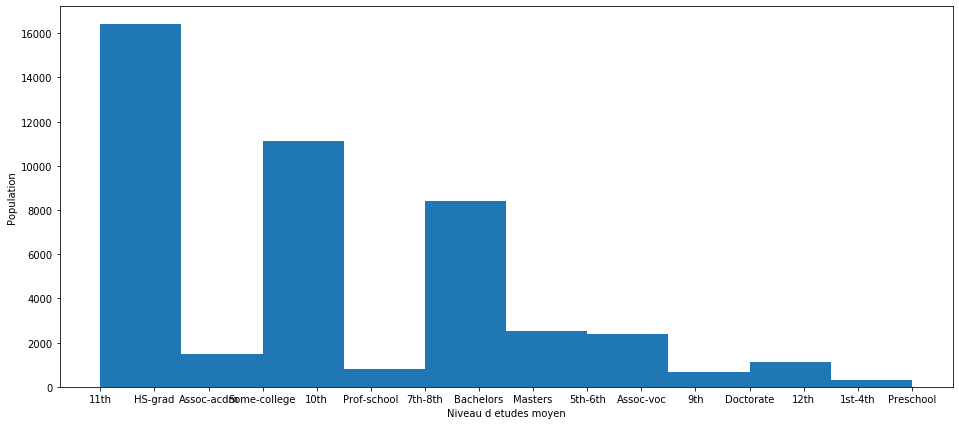

In [157]:
plt.figure(figsize=(16, 7))
plt.xlabel('Niveau d etudes moyen')
plt.ylabel('Population')
plt.hist(df_modified['education'])

Comme nous l'avions vu avec l'exemple de la demo4, nous savons que le jeu de donnee
est debalance. Tant au niveau de la representation de la population originaire des Etats-Unis,
ou bien par le nombre d'individus qui ont un salaire a 50k, ou encore la part des Femmes et des Hommes.

## Recherche de patrons

Comptenu de la taille des donnees meme apres les avoirs nettoyes, nous avons decide de voir quels patrons pouvons-nous retrouver a l'aide d'un FP-Tree. On effectuera plusieurs fois l'algorithme avec des ensembles de donnees differents pour voir si nous obtenons souvent les memes elements, ou bien si il y a quelques variations dans les donnees.


### Recherche de patrons avec l'algorithme A-Priori

Compte tenu de nos tests avec le FP-Tree vu au cours sur le jeu de donnees "adult.csv", nous avons decidé de nous concentrer d'abord avec un algorithme A-Priori. Cette approche est de toute evidence plus lente en terme de temps de calcul, mais elle est celle qui utilise le moins de memoire et risque moins de faire planter  JupyterNotebook.

fnlwgt serait quelques chose de similaire a un Identifiant personnel, on estime que l'on en a pas besoin dans nos donnees. 
De meme qie la colonne 'education-num' puisque nous pouvons deja connaitre le niveua de scolarite de l'individu puisque celui-ci est explicite.

In [158]:
df.drop(['fnlwgt', 'educational-num'], axis=1, inplace=True)
df.head()

age  workclass     education      marital-status         occupation  \
0   25    Private          11th       Never-married  Machine-op-inspct   
1   38    Private       HS-grad  Married-civ-spouse    Farming-fishing   
2   28  Local-gov    Assoc-acdm  Married-civ-spouse    Protective-serv   
3   44    Private  Some-college  Married-civ-spouse  Machine-op-inspct   
4   18          ?  Some-college       Never-married                  ?   

  relationship   race  gender  capital-gain  capital-loss  hours-per-week  \
0    Own-child  Black    Male             0             0              40   
1      Husband  White    Male             0             0              50   
2      Husband  White    Male             0             0              40   
3      Husband  Black    Male          7688             0              40   
4    Own-child  White  Female             0             0              30   

  native-country income  
0  United-States  <=50K  
1  United-States  <=50K  
2  United-States   >50K  
3  United-States   >50K  
4  United-States  <=50K

Le jeu de donnees possede des valeurs manquantes qui sont representees par des '?'. 
On decide (arbitrairement) de les retirer dans presque toutes les colonnes sauf celles du pays d'origine pour ne pas 'polluer' nos donnees.

In [159]:
df = df.replace(' ?', np.NaN)
df.dropna(axis = 0, inplace = True)
df.reset_index(drop= True, inplace= True)
df.head(50)

age         workclass     education      marital-status  \
0    25           Private          11th       Never-married   
1    38           Private       HS-grad  Married-civ-spouse   
2    28         Local-gov    Assoc-acdm  Married-civ-spouse   
3    44           Private  Some-college  Married-civ-spouse   
4    18                 ?  Some-college       Never-married   
5    34           Private          10th       Never-married   
6    29                 ?       HS-grad       Never-married   
7    63  Self-emp-not-inc   Prof-school  Married-civ-spouse   
8    24           Private  Some-college       Never-married   
9    55           Private       7th-8th  Married-civ-spouse   
10   65           Private       HS-grad  Married-civ-spouse   
11   36       Federal-gov     Bachelors  Married-civ-spouse   
12   26           Private       HS-grad       Never-married   
13   58                 ?       HS-grad  Married-civ-spouse   
14   48           Private       HS-grad  Married-civ-spouse   
15   43           Private       Masters  Married-civ-spouse   
16   20         State-gov  Some-college       Never-married   
17   43           Private       HS-grad  Married-civ-spouse   
18   37           Private       HS-grad             Widowed   
19   40           Private     Doctorate  Married-civ-spouse   
20   34           Private     Bachelors  Married-civ-spouse   
21   34           Private  Some-college       Never-married   
22   72                 ?       7th-8th            Divorced   
23   25           Private     Bachelors       Never-married   
24   25           Private     Bachelors  Married-civ-spouse   
25   45  Self-emp-not-inc       HS-grad  Married-civ-spouse   
26   22           Private       HS-grad       Never-married   
27   23           Private       HS-grad           Separated   
28   54           Private       HS-grad  Married-civ-spouse   
29   32  Self-emp-not-inc  Some-college       Never-married   
30   46         State-gov  Some-college  Married-civ-spouse   
31   56  Self-emp-not-inc          11th             Widowed   
32   24  Self-emp-not-inc     Bachelors       Never-married   
33   23         Local-gov  Some-college  Married-civ-spouse   
34   26           Private       HS-grad            Divorced   
35   65                 ?       HS-grad  Married-civ-spouse   
36   36         Local-gov     Bachelors  Married-civ-spouse   
37   22           Private       5th-6th       Never-married   
38   17           Private          10th       Never-married   
39   20           Private       HS-grad       Never-married   
40   65           Private       Masters  Married-civ-spouse   
41   44      Self-emp-inc     Assoc-voc  Married-civ-spouse   
42   36           Private       HS-grad  Married-civ-spouse   
43   29           Private          11th  Married-civ-spouse   
44   20         State-gov  Some-college       Never-married   
45   28           Private     Assoc-voc  Married-civ-spouse   
46   39           Private       7th-8th  Married-civ-spouse   
47   54           Private  Some-college  Married-civ-spouse   
48   52           Private          11th           Separated   
49   56      Self-emp-inc       HS-grad             Widowed   

           occupation   relationship                race  gender  \
0   Machine-op-inspct      Own-child               Black    Male   
1     Farming-fishing        Husband               White    Male   
2     Protective-serv        Husband               White    Male   
3   Machine-op-inspct        Husband               Black    Male   
4                   ?      Own-child               White  Female   
5       Other-service  Not-in-family               White    Male   
6                   ?      Unmarried               Black    Male   
7      Prof-specialty        Husband               White    Male   
8       Other-service      Unmarried               White  Female   
9        Craft-repair        Husband               White    Male   
10  Machine-op-inspct        Husband      

Pour pouvoir appliquer l'algorithme A-Priori sur notre jeu de donnees, nous devont transmorfer certaines donnees en donnees categorielles, pour pouvoir generer des regles d'association. 
On convertit donc des variables continues et non explicites en variables discretes. 
Notons que nous perdons bien evidemment en precision.

In [160]:
df['age'] = pd.cut(df['age'], bins = [0, 25, 50, 100],
						 labels = ['Jeune-Adulte', 'Adulte', 'Aine'],
						 right = True, include_lowest = True)

df['hours-per-week'] = pd.cut(df['hours-per-week'], [0, 30, 45, 100],
										labels = ['Temps_partiel', 'Temps_plein', 'Temps_supplementaire'],
										right = True, include_lowest = True)

df['capital-gain'] = pd.cut(df['capital-gain'], [0, 1, 50000, 100000],
									 labels = ['No_capital_Gain', 'Medium_capital_Gain', 'High_capital_Gain'],
									 right = True, include_lowest = True)

df['capital-loss'] = pd.cut(df['capital-loss'], [0, 1, 50000, 100000],
									 labels = ['No_capital_Loss', 'Medium_capital_loss', 'High_capital_Loss'],
									 right = True, include_lowest = True)
df.head()

age  workclass     education      marital-status  \
0  Jeune-Adulte    Private          11th       Never-married   
1        Adulte    Private       HS-grad  Married-civ-spouse   
2        Adulte  Local-gov    Assoc-acdm  Married-civ-spouse   
3        Adulte    Private  Some-college  Married-civ-spouse   
4  Jeune-Adulte          ?  Some-college       Never-married   

          occupation relationship   race  gender         capital-gain  \
0  Machine-op-inspct    Own-child  Black    Male      No_capital_Gain   
1    Farming-fishing      Husband  White    Male      No_capital_Gain   
2    Protective-serv      Husband  White    Male      No_capital_Gain   
3  Machine-op-inspct      Husband  Black    Male  Medium_capital_Gain   
4                  ?    Own-child  White  Female      No_capital_Gain   

      capital-loss        hours-per-week native-country income  
0  No_capital_Loss           Temps_plein  United-States  <=50K  
1  No_capital_Loss  Temps_supplementaire  United-States  <=50K  
2  No_capital_Loss           Temps_plein  United-States   >50K  
3  No_capital_Loss           Temps_plein  United-States   >50K  
4  No_capital_Loss         Temps_partiel  United-States  <=50K

Le fait de creer des categories d'ages et economiques pour simpifier l'interpretation des donnees permet indirectement d'annonimiser les donnees a un certain degre. On ne peut obtenir qu'un renseignement sur la plage d'age d'un individu plutot que son age exact. Il en est de meme pour le gain ou la perte de capital. Supposons qu'une banque grace a cette base de donnees, veuilles connaitre le potentiel de solvabilité d'un individu. Bien entendu, on va dans notre exemple, se concentrer que sur l'age, le temps de travail et le gain de capitaux (car les donnees donnent aussi beaucoup de renseignements), il sera plus difficile de situer qu'est-ce qui est une situation financiere qui implique peut de risques pour la banque, si dans la base de donnees, on voit apparaitre **medium/High_capital_gain**. La banque ne serait pas en mesure de definir quel serait le seuil par exemple. 

En revanche, notre base de donnees devaforiserait grandement les personnes ayant subit soit une forte perte de capitaux, soit une personne n'ayant pas gagne de capitaux. Car on est certain que la perte ou le gain est significative (ou non) si cet individu se trouve dans cette categorie. L'idee serait que la majeure partie se trouve dans la categorie moyenne, mais qu'un petite proportion se retrouve dans les extremes. On pourrait donc avoir une idee si cette personne se retrouve dans l'elite de la population en cas de gains importants, ou a l'inverse, dans une mauvaise passe financiere.

De meme que pour l'age de la personne consultee, **Jeune-adulte** pourrait tres bien etre une personne tout juste majeure, ou bien une personne etant sur le marche du travail depuis quelques annees deja, apres avoir termine des etudes superieures.

#### Le code de l'algorithme A-priori

In [161]:
def get_candidates(dataFrame):

	temp_candidates = {}

	for index, row in dataFrame.iterrows():
		# Convertit chaque ligne du jeu de donnees en une transaction
		transaction = list(set(row))
		'''
			Chaque element de la transaction est un item. Le mombre de chaque item est contenu dans
			un dictionnaire (key,value)
		'''
		for item in transaction:
			if (item in temp_candidates.keys()):
				temp_candidates[item] += 1
			else:
				temp_candidates[item] = 1
	return temp_candidates
	
def generateLevelOneSubstets(d, c, minSupport):

	for key,value in c.items():
		if (value >= minSupport):
			d[key] = value
	return d
	
def join(frequentItemsets, k):
	cand_sets = []
	total_items = list(frequentItemsets.keys())
	singleUniqueElements = set()
	if (k>2):
		for item in set(total_items):
			singleUniqueElements = singleUniqueElements.union(item)
	else:
		singleUniqueElements = set(total_items)

	cand_sets = list(combinations(singleUniqueElements, k))

	return cand_sets


#On efface les sous-ensemble peu frequents
def has_infrequent_subset(item, prevFreqSet, k):
	
	candSubsets = set(combinations(item,(k-1)))
	
	if (not(candSubsets.issubset(prevFreqSet))):
		return True

	return False

#Compte le support de chaque transaction candidate
def getSupportCount(candidateItemsets,dataFrame):
	
	candidateSets = {key:0 for key in candidateItemsets}
	
	for key,value in candidateSets.items():
		for index,row in dataFrame.iterrows():
			if(set(key).issubset(set(row))):
				candidateSets[key] += 1
				
	return candidateSets

def afficherCandidats(k, candidateItemsets, previousFrequentItemsets, minSupport, dataFrame):
	
	candidates ={}
	prevFreqSet = set(previousFrequentItemsets)

	for item in candidateItemsets:
		if(has_infrequent_subset(item, prevFreqSet, k)):
			candidateItemsets.remove(item)

	candidates = getSupportCount(candidateItemsets,dataFrame)
	print("Ensembles candidats:\n", candidates)
	
	return candidates

#Genere les sous-ensemble de niveau-K
def generateLevelKSubstets(candidateItemsets, minSupport):
	
	frequentItemsets = {}
	
	for item,count in candidateItemsets.items():
		if (count >= minSupport):
			frequentItemsets[item] = count

	return frequentItemsets

def aPriori(dataFrame, minSupportPercentage):

	minSupport = round((minSupportPercentage / 100.0) * len(dataFrame.index))
	print ('Minimum Support Count = ', minSupport)
	
	# Generating the 1st set of candidates C1
	candidateItemsets = get_candidates(dataFrame)
	
	# Generating 1st set of frequent itemsets L1
	frequentItemsets = {}
	frequentItemsets = generateLevelOneSubstets(frequentItemsets, candidateItemsets, minSupport)

	#totalFrequentItemsets = len(frequentItemsets)
	iteration = 1
	
	finalFrequentItemsets = {}
	finalFrequentItemsets.update(frequentItemsets)

	print('Ensemble de caracteristiques frequentes N-1 : \n')
	for key,value in frequentItemsets.items():
		print(key, ' : ', value)
	
	while True:
		iteration += 1
		candidateItemsets = join(frequentItemsets, iteration)
		candidateItemsets = afficherCandidats(iteration, candidateItemsets,
										  frequentItemsets, minSupport, dataFrame)
		frequentItemsets = generateLevelKSubstets(candidateItemsets, minSupport)
		finalFrequentItemsets.update(frequentItemsets)
		
		if (bool(frequentItemsets)):
			print('Ensemble de caracteristiques frequentes N-',iteration, 'iterations: \n')
			for key,value in frequentItemsets.items():
				print(key, ' : ', value, '\n')
		if len(frequentItemsets) == 0:
			print('All frequent patterns: \n')
			for key,value in finalFrequentItemsets.items():
				print(key, ' : ', value)
			break
	return
	
#Algorithme A-priori donnant un meilleur resultat en definissant un seuil de support minimal
# Et en utilisant un facteur aleatoire pour melanger la selection des donnees
def sampled_apriori(df, minSup, samplingFactor):
	
	#Perform a random sample of the dataframe
	df = df.sample(frac = samplingFactor).reset_index(drop = True)
	
	# We lower the minimum support in hope of capturing all global frequent patterns
	minSup = minSup*0.9
	
	startTime = time.time()
	aPriori(df, minSup)
	totalRunTime = time.time() - startTime
	print ('\n\n Total Execution Time: ', totalRunTime)

def benchmark_data(df,minSupport, samplingFactor):
	startTime = time.time()
	aPriori(df,60)
	totalRunTime = time.time() - startTime
	print ('\n Total Execution Time: ', totalRunTime)
	sampled_apriori(df,minSupport,samplingFactor)


### Division des jeux de données

Enfin nous allons diviser et etudier le comprotement de A-priori sur divers jeux de donnees car,
comme nous l'avons vu plus haut et a la demonstration 8, le jeu de donnees est severement debalance.
La population Nord-Americaine y est sur-representee, ainsi que la population Caucasienne masculine ayant
un salaire <= 50K. Nous allons donc faires quelques divisions des ensembles de donnees pour observer 
les differents patrons qui seront generes.

In [162]:
# DataFrame avec les donnees des individus gagnant plus de >50k
dfOver50K = df[df['income'] == ">50K"]

#Population hors USA
dfLessUSA = df[df['native-country'] != "United-States"]

#Population hors USA gagnant plus de >50k
dfLessUSAOver50K = dfLessUSA[dfLessUSA['income'] == ">50K"]

#Population hors USA gagnant moins de <=50k
dfLessUSALess50K = dfLessUSA[dfLessUSA['income'] == "<=50K"]

#Population hors USA Feminine
dfLessUSAFemale = dfLessUSA[dfLessUSA['gender'] != "Male"]

#Population hors USA Feminine gagant un salaire de plus de >50k
dfLessUSAFemaleLess50K = dfLessUSAFemale[dfLessUSAFemale['income'] == "<=50K"]

#Population hors USA Feminine gagant un salaire de plus de >50k
dfLessUSAFemaleOver50K = dfLessUSAFemale[dfLessUSAFemale['income'] == ">50K"]

#Population non caucasienne 
dfLessCaucasian = df[df['race'] != "White"]

#Population non caucasienne <=50K
dfLessCaucasianLess50K = dfLessCaucasian[dfLessCaucasian['income'] == "<=50K"]

#Population non caucasienne >50K
dfLessCaucasianOver50K = dfLessCaucasian[dfLessCaucasian['income'] == ">50K"]

#Population hors USA non caucasienne <=50K
temp = dfLessUSA[dfLessUSA['income'] == "<=50K"]
dfLessCaucasianLessUSALess50K = temp[temp['race'] != "White"]

#Population hors USA non caucasienne >50K
temp = dfLessUSA[dfLessUSA['income'] == ">50K"]
dfLessCaucasianLessUSAOver50K = temp[temp['race'] != "White"]

#Population hors USA non caucasienne <=50K
temp = dfLessUSA[dfLessUSA['income'] == "<=50K"]
temp = temp[temp['race'] != "White"]
dfLessCaucasianLessBlackLessUSALess50K = temp[temp['race'] != "Black"]

#Population hors USA non caucasienne >50K
temp = dfLessUSA[dfLessUSA['income'] == ">50K"]
temp = temp[temp['race'] != "White"]
dfLessCaucasianLessBlackLessUSAOver50K = temp[temp['race'] != "Black"]

#### Anonymisation des donnees sur la categorie de revenus

Nous avons decide lors de la separation des donnees pour les differentes tables, d'enlever la colonne indiquant la fourchette de revenus. Ceci permet d'un peut plus rendre les personnes moins distinguables, car meme si on sait que en general, le niveau d'etude, le secteur ainsi que l'origine ethnique et le genre determine donne en grande partie une idee du revenu d'une personne (malheureusement), on veut que dans une eventuelle interception des donnees, rendre le croisement des informations le plus difficile possible. Laisser la colonne du type de revenu est une solution naive et simple a un probleme beaucoup plus complexe, mais il faut neanmoins que nous puissions encore pouvoir interpreter nos donnees et les patrons subsequents.

En stockant les donnees sans le renseignement sur le revenu, nous estimons un peu plus d'anonymiser les donnees tout en gardant a l'esprit le type de comparaisons que nous faisons.

In [163]:
dfOver50K.drop(['income'], axis=1, inplace=True)
dfLessUSA.drop(['income'], axis=1, inplace=True)
dfLessUSAOver50K.drop(['income'], axis=1, inplace=True)
dfLessUSALess50K.drop(['income'], axis=1, inplace=True)
dfLessUSAFemale.drop(['income'], axis=1, inplace=True)
dfLessUSAFemaleLess50K.drop(['income'], axis=1, inplace=True)
dfLessUSAFemaleOver50K.drop(['income'], axis=1, inplace=True)
dfLessCaucasian.drop(['income'], axis=1, inplace=True)
dfLessCaucasianLess50K.drop(['income'], axis=1, inplace=True)
dfLessCaucasianOver50K.drop(['income'], axis=1, inplace=True)
dfLessCaucasianLessUSALess50K.drop(['income'], axis=1, inplace=True)
dfLessCaucasianLessUSAOver50K.drop(['income'], axis=1, inplace=True)
dfLessCaucasianLessBlackLessUSALess50K.drop(['income'], axis=1, inplace=True)
dfLessCaucasianLessBlackLessUSAOver50K.drop(['income'], axis=1, inplace=True)
dfLessUSA.head()

age workclass  education         marital-status       occupation  \
19        Adulte   Private  Doctorate     Married-civ-spouse   Prof-specialty   
23  Jeune-Adulte   Private  Bachelors          Never-married   Prof-specialty   
37  Jeune-Adulte   Private    5th-6th          Never-married  Priv-house-serv   
46        Adulte   Private    7th-8th     Married-civ-spouse     Craft-repair   
54        Adulte   Private        9th  Married-spouse-absent  Exec-managerial   

     relationship                race gender     capital-gain  \
19        Husband  Asian-Pac-Islander   Male  No_capital_Gain   
23  Not-in-family               White   Male  No_capital_Gain   
37  Not-in-family               White   Male  No_capital_Gain   
46        Husband               White   Male  No_capital_Gain   
54  Not-in-family               White   Male  No_capital_Gain   

       capital-loss        hours-per-week native-country  
19  No_capital_Loss           Temps_plein              ?  
23  No_capital_Loss           Temps_plein           Peru  
37  No_capital_Loss  Temps_supplementaire      Guatemala  
46  No_capital_Loss           Temps_plein         Mexico  
54  No_capital_Loss  Temps_supplementaire         Mexico

##### Petite Optimisation sur l'algorithme A-Priori
On peut obtenir de meilleurs resultats en forcant un taux de support minimum plus bas et en melangeant les donnees

In [164]:
#Algorithme A-priori donnant un meilleur resultat en definissant un seuil de support minimal
# Et en utilisant un facteur aleatoire pour melanger la selection des donnees
def sampled_apriori(df, minSup, samplingFactor):
	
	#Perform a random sample of the dataframe
	df = df.sample(frac = samplingFactor).reset_index(drop = True)
	
	# We lower the minimum support in hope of capturing all global frequent patterns
	minSup = minSup*0.9
	
	startTime = time.time()
	aPriori(df, minSup)
	totalRunTime = time.time() - startTime
	print ('\n\n Total Execution Time: ', totalRunTime)

benchmark_data(df,70,0.5)

Minimum Support Count =  29305
Ensemble de caracteristiques frequentes N-1 : 

Private  :  33906
Male  :  32650
No_capital_Loss  :  46560
<=50K  :  37155
No_capital_Gain  :  44807
Temps_plein  :  30290
United-States  :  43832
White  :  41762
Adulte  :  29407
Ensembles candidats:
 {('White', 'Private'): 29024, ('White', 'No_capital_Loss'): 39742, ('White', 'Temps_plein'): 25289, ('White', 'United-States'): 38493, ('Male', '<=50K'): 22732, ('Male', 'No_capital_Gain'): 29553, ('Male', 'Adulte'): 20422, ('Private', '<=50K'): 26519, ('Private', 'No_capital_Gain'): 31326, ('Private', 'Adulte'): 20879, ('<=50K', 'No_capital_Loss'): 36017, ('<=50K', 'Temps_plein'): 23581, ('<=50K', 'United-States'): 33138, ('No_capital_Loss', 'Temps_plein'): 28934, ('No_capital_Loss', 'United-States'): 41752, ('No_capital_Gain', 'Adulte'): 26838, ('Temps_plein', 'Adulte'): 19362, ('Adulte', 'United-States'): 26185}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('White', 'No_capital_Loss')  :  3974

### Extrapoler sur les donnees marginales

Profil type de la population generale

In [165]:
benchmark_data(df,70,0.5)

Minimum Support Count =  29305
Ensemble de caracteristiques frequentes N-1 : 

Private  :  33906
Male  :  32650
No_capital_Loss  :  46560
<=50K  :  37155
No_capital_Gain  :  44807
Temps_plein  :  30290
United-States  :  43832
White  :  41762
Adulte  :  29407
Ensembles candidats:
 {('White', 'Private'): 29024, ('White', 'No_capital_Loss'): 39742, ('White', 'Temps_plein'): 25289, ('White', 'United-States'): 38493, ('Male', '<=50K'): 22732, ('Male', 'No_capital_Gain'): 29553, ('Male', 'Adulte'): 20422, ('Private', '<=50K'): 26519, ('Private', 'No_capital_Gain'): 31326, ('Private', 'Adulte'): 20879, ('<=50K', 'No_capital_Loss'): 36017, ('<=50K', 'Temps_plein'): 23581, ('<=50K', 'United-States'): 33138, ('No_capital_Loss', 'Temps_plein'): 28934, ('No_capital_Loss', 'United-States'): 41752, ('No_capital_Gain', 'Adulte'): 26838, ('Temps_plein', 'Adulte'): 19362, ('Adulte', 'United-States'): 26185}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('White', 'No_capital_Loss')  :  3974

Profil type de la population ayant un salaire >=50K

In [166]:
benchmark_data(dfOver50K,70,0.5)

Minimum Support Count =  7012
Ensemble de caracteristiques frequentes N-1 : 

White  :  10607
Male  :  9918
No_capital_Loss  :  10543
No_capital_Gain  :  9196
Husband  :  8846
Married-civ-spouse  :  9984
Adulte  :  8397
United-States  :  10694
Private  :  7387
Ensembles candidats:
 {('White', 'Private'): 6742, ('White', 'No_capital_Gain'): 8359, ('White', 'Married-civ-spouse'): 9102, ('White', 'United-States'): 9992, ('Male', 'No_capital_Loss'): 8933, ('Male', 'Husband'): 8846, ('Male', 'Adulte'): 7042, ('Private', 'No_capital_Loss'): 6673, ('Private', 'Husband'): 5592, ('Private', 'Adulte'): 5595, ('No_capital_Loss', 'No_capital_Gain'): 8052, ('No_capital_Loss', 'Married-civ-spouse'): 8982, ('No_capital_Loss', 'United-States'): 9645, ('No_capital_Gain', 'Married-civ-spouse'): 7992, ('No_capital_Gain', 'United-States'): 8407, ('Husband', 'Adulte'): 6261, ('Married-civ-spouse', 'Adulte'): 7185, ('Adulte', 'United-States'): 7682}
Ensemble de caracteristiques frequentes N- 2 iterations: 


Ensemble de caracteristiques frequentes N-1 : 

White  :  5282
Male  :  4965
No_capital_Loss  :  5251
Husband  :  4407
Married-civ-spouse  :  4980
Adulte  :  4219
United-States  :  5334
Private  :  3715
No_capital_Gain  :  4610
Ensembles candidats:
 {('White', 'Private'): 3367, ('White', 'No_capital_Gain'): 4171, ('White', 'Married-civ-spouse'): 4522, ('White', 'United-States'): 4979, ('Male', 'No_capital_Loss'): 4455, ('Male', 'Husband'): 4407, ('Male', 'Adulte'): 3552, ('Private', 'No_capital_Loss'): 3339, ('Private', 'Husband'): 2793, ('Private', 'Adulte'): 2843, ('No_capital_Loss', 'No_capital_Gain'): 4017, ('No_capital_Loss', 'Married-civ-spouse'): 4472, ('No_capital_Loss', 'United-States'): 4789, ('No_capital_Gain', 'Married-civ-spouse'): 4000, ('No_capital_Gain', 'United-States'): 4212, ('Husband', 'Adulte'): 3145, ('Married-civ-spouse', 'Adulte'): 3608, ('Adulte', 'United-States'): 3868}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('White', 'No_capital_Gain')  : 

Profil type d'une population hors USA

In [167]:
benchmark_data(dfLessUSA,70,0.5)

Minimum Support Count =  3006
Ensemble de caracteristiques frequentes N-1 : 

Private  :  3761
Male  :  3427
No_capital_Loss  :  4808
No_capital_Gain  :  4661
Temps_plein  :  3379
Adulte  :  3222
White  :  3269
Ensembles candidats:
 {('White', 'Private'): 2484, ('White', 'No_capital_Gain'): 3044, ('White', 'Adulte'): 2032, ('Male', 'No_capital_Loss'): 3271, ('Male', 'Temps_plein'): 2309, ('Private', 'No_capital_Loss'): 3628, ('Private', 'Temps_plein'): 2699, ('No_capital_Loss', 'No_capital_Gain'): 4459, ('No_capital_Loss', 'Adulte'): 3079, ('No_capital_Gain', 'Adulte'): 3006}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('White', 'No_capital_Gain')  :  3044 

('Male', 'No_capital_Loss')  :  3271 

('Private', 'No_capital_Loss')  :  3628 

('No_capital_Loss', 'No_capital_Gain')  :  4459 

('No_capital_Loss', 'Adulte')  :  3079 

('No_capital_Gain', 'Adulte')  :  3006 

Ensembles candidats:
 {('White', 'No_capital_Gain', 'Male'): 2110, ('White', 'No_capital_Gain', 'No_capit

Profil type d'une population hors USA ayant un salaire >= 50k

In [168]:
benchmark_data(dfLessUSAOver50K,70,0.5)

Minimum Support Count =  596
Ensemble de caracteristiques frequentes N-1 : 

Private  :  622
Male  :  837
No_capital_Loss  :  898
No_capital_Gain  :  789
Husband  :  727
Temps_plein  :  600
Married-civ-spouse  :  843
Adulte  :  715
White  :  615
Ensembles candidats:
 {('White', 'Private'): 382, ('White', 'No_capital_Gain'): 492, ('White', 'Temps_plein'): 343, ('White', 'Adulte'): 417, ('Male', 'No_capital_Loss'): 752, ('Male', 'Husband'): 727, ('Male', 'Married-civ-spouse'): 731, ('Private', 'No_capital_Loss'): 566, ('Private', 'Husband'): 447, ('Private', 'Married-civ-spouse'): 520, ('No_capital_Loss', 'No_capital_Gain'): 694, ('No_capital_Loss', 'Temps_plein'): 552, ('No_capital_Loss', 'Adulte'): 648, ('No_capital_Gain', 'Temps_plein'): 497, ('No_capital_Gain', 'Adulte'): 590, ('Husband', 'Married-civ-spouse'): 727, ('Temps_plein', 'Married-civ-spouse'): 521, ('Married-civ-spouse', 'Adulte'): 601}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Male', 'No_capital_Loss') 

Profil type d'une population hors USA ayant un salaire < 50k

In [169]:
benchmark_data(dfLessUSALess50K,70,0.5)

Minimum Support Count =  2410
Ensemble de caracteristiques frequentes N-1 : 

White  :  2654
Private  :  3139
Male  :  2590
No_capital_Loss  :  3910
No_capital_Gain  :  3872
Temps_plein  :  2779
Adulte  :  2507
Ensembles candidats:
 {('White', 'Private'): 2102, ('White', 'No_capital_Gain'): 2552, ('White', 'Adulte'): 1615, ('Male', 'No_capital_Loss'): 2519, ('Male', 'Temps_plein'): 1808, ('Private', 'No_capital_Loss'): 3062, ('Private', 'Temps_plein'): 2301, ('No_capital_Loss', 'No_capital_Gain'): 3765, ('No_capital_Loss', 'Adulte'): 2431, ('No_capital_Gain', 'Adulte'): 2416}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('White', 'No_capital_Gain')  :  2552 

('Male', 'No_capital_Loss')  :  2519 

('Private', 'No_capital_Loss')  :  3062 

('No_capital_Loss', 'No_capital_Gain')  :  3765 

('No_capital_Loss', 'Adulte')  :  2431 

('No_capital_Gain', 'Adulte')  :  2416 

Ensembles candidats:
 {('White', 'No_capital_Gain', 'Male'): 1692, ('White', 'No_capital_Gain', 'No_capit

Profil type d'une population hors USA et Feminine

In [170]:
benchmark_data(dfLessUSAFemale,70,0.5)

Minimum Support Count =  950
Ensemble de caracteristiques frequentes N-1 : 

White  :  984
Female  :  1583
Private  :  1207
No_capital_Loss  :  1537
No_capital_Gain  :  1512
Temps_plein  :  1070
Adulte  :  968
Ensembles candidats:
 {('White', 'Private'): 743, ('White', 'No_capital_Gain'): 934, ('White', 'Adulte'): 568, ('Female', 'No_capital_Loss'): 1537, ('Female', 'Temps_plein'): 1070, ('Private', 'No_capital_Loss'): 1172, ('Private', 'Temps_plein'): 856, ('No_capital_Loss', 'No_capital_Gain'): 1466, ('No_capital_Loss', 'Adulte'): 939, ('No_capital_Gain', 'Adulte'): 922}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Female', 'No_capital_Loss')  :  1537 

('Female', 'Temps_plein')  :  1070 

('Private', 'No_capital_Loss')  :  1172 

('No_capital_Loss', 'No_capital_Gain')  :  1466 

Ensembles candidats:
 {('Female', 'Private', 'No_capital_Gain'): 1161, ('Female', 'No_capital_Loss', 'No_capital_Gain'): 1466, ('Female', 'No_capital_Gain', 'Temps_plein'): 1030, ('Private', 

Profil type d'une population hors USA et Feminine ayant un salaire >= 50k

In [171]:
benchmark_data(dfLessUSAFemaleOver50K,70,0.5)

Minimum Support Count =  94
Ensemble de caracteristiques frequentes N-1 : 

White  :  95
Female  :  156
No_capital_Loss  :  146
No_capital_Gain  :  124
Wife  :  107
Temps_plein  :  99
Married-civ-spouse  :  112
Adulte  :  125
Private  :  98
Ensembles candidats:
 {('White', 'Private'): 60, ('White', 'No_capital_Gain'): 74, ('White', 'Temps_plein'): 55, ('White', 'Adulte'): 72, ('Female', 'No_capital_Loss'): 146, ('Female', 'Wife'): 107, ('Female', 'Married-civ-spouse'): 112, ('Private', 'No_capital_Loss'): 91, ('Private', 'Wife'): 67, ('Private', 'Married-civ-spouse'): 70, ('No_capital_Loss', 'No_capital_Gain'): 114, ('No_capital_Loss', 'Temps_plein'): 93, ('No_capital_Loss', 'Adulte'): 117, ('No_capital_Gain', 'Temps_plein'): 84, ('No_capital_Gain', 'Adulte'): 102, ('Wife', 'Married-civ-spouse'): 106, ('Temps_plein', 'Married-civ-spouse'): 72, ('Married-civ-spouse', 'Adulte'): 92}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Female', 'No_capital_Loss')  :  146 

('Femal

Profil type d'une population hors USA et Feminine ayant un salaire < 50k


In [172]:
benchmark_data(dfLessUSAFemaleLess50K,70,0.5)

Minimum Support Count =  856
Ensemble de caracteristiques frequentes N-1 : 

White  :  889
Female  :  1427
Private  :  1109
No_capital_Loss  :  1391
No_capital_Gain  :  1388
Temps_plein  :  971
Ensembles candidats:
 {('White', 'Private'): 683, ('White', 'No_capital_Gain'): 860, ('Female', 'Private'): 1109, ('Female', 'No_capital_Gain'): 1388, ('Private', 'No_capital_Loss'): 1081, ('Private', 'Temps_plein'): 795, ('No_capital_Loss', 'Temps_plein'): 948}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('White', 'No_capital_Gain')  :  860 

('Female', 'Private')  :  1109 

('Female', 'No_capital_Gain')  :  1388 

('Private', 'No_capital_Loss')  :  1081 

('No_capital_Loss', 'Temps_plein')  :  948 

Ensembles candidats:
 {('White', 'No_capital_Gain', 'Female'): 860, ('White', 'No_capital_Gain', 'No_capital_Loss'): 839, ('White', 'Temps_plein', 'Private'): 485, ('White', 'Female', 'Private'): 683, ('White', 'Private', 'No_capital_Loss'): 667, ('No_capital_Gain', 'Temps_plein', 'P

Profil type d'une population non Caucasienne

In [173]:
benchmark_data(dfLessCaucasian,70,0.5)

Minimum Support Count =  4248
Ensemble de caracteristiques frequentes N-1 : 

Private  :  4882
Black  :  4685
No_capital_Loss  :  6818
No_capital_Gain  :  6623
Temps_plein  :  5001
United-States  :  5339
Adulte  :  4519
Ensembles candidats:
 {('Private', 'No_capital_Loss'): 4714, ('Private', 'Temps_plein'): 3535, ('Private', 'United-States'): 3605, ('Black', 'No_capital_Gain'): 4409, ('Black', 'Adulte'): 2959, ('No_capital_Loss', 'No_capital_Gain'): 6361, ('No_capital_Loss', 'Adulte'): 4346, ('No_capital_Gain', 'Temps_plein'): 4692, ('No_capital_Gain', 'United-States'): 5006, ('Temps_plein', 'United-States'): 3805}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Private', 'No_capital_Loss')  :  4714 

('Black', 'No_capital_Gain')  :  4409 

('No_capital_Loss', 'No_capital_Gain')  :  6361 

('No_capital_Loss', 'Adulte')  :  4346 

('No_capital_Gain', 'Temps_plein')  :  4692 

('No_capital_Gain', 'United-States')  :  5006 

Ensembles candidats:
 {('No_capital_Gain', 'Temps_p

Profil type d'une population non Caucasienne ayant un salaire >= 50K

In [174]:
benchmark_data(dfLessCaucasianOver50K,70,0.5)

Minimum Support Count =  648
Ensemble de caracteristiques frequentes N-1 : 

Male  :  853
No_capital_Loss  :  981
Husband  :  739
Temps_plein  :  730
Married-civ-spouse  :  882
Adulte  :  819
United-States  :  702
No_capital_Gain  :  837
Ensembles candidats:
 {('Male', 'No_capital_Gain'): 663, ('Male', 'Temps_plein'): 571, ('Male', 'Adulte'): 635, ('No_capital_Loss', 'No_capital_Gain'): 738, ('No_capital_Loss', 'Temps_plein'): 669, ('No_capital_Loss', 'Adulte'): 742, ('No_capital_Gain', 'Husband'): 594, ('No_capital_Gain', 'Married-civ-spouse'): 708, ('No_capital_Gain', 'United-States'): 540, ('Husband', 'Married-civ-spouse'): 739, ('Husband', 'United-States'): 462, ('Temps_plein', 'Adulte'): 547, ('Married-civ-spouse', 'Adulte'): 670, ('Adulte', 'United-States'): 521}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Male', 'No_capital_Gain')  :  663 

('No_capital_Loss', 'No_capital_Gain')  :  738 

('No_capital_Loss', 'Temps_plein')  :  669 

('No_capital_Loss', 'Adulte')

Profil type d'une population non Caucasienne ayant un salaire < 50K

In [175]:
benchmark_data(dfLessCaucasianLess50K,70,0.5)

Minimum Support Count =  3600
Ensemble de caracteristiques frequentes N-1 : 

Private  :  4237
Black  :  4119
No_capital_Loss  :  5837
No_capital_Gain  :  5786
Temps_plein  :  4271
United-States  :  4637
Adulte  :  3700
Ensembles candidats:
 {('Private', 'No_capital_Loss'): 4129, ('Private', 'Temps_plein'): 3084, ('Private', 'United-States'): 3200, ('Black', 'No_capital_Gain'): 3979, ('Black', 'Adulte'): 2539, ('No_capital_Loss', 'No_capital_Gain'): 5623, ('No_capital_Loss', 'Adulte'): 3604, ('No_capital_Gain', 'Temps_plein'): 4123, ('No_capital_Gain', 'United-States'): 4466, ('Temps_plein', 'United-States'): 3332}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Private', 'No_capital_Loss')  :  4129 

('Black', 'No_capital_Gain')  :  3979 

('No_capital_Loss', 'No_capital_Gain')  :  5623 

('No_capital_Loss', 'Adulte')  :  3604 

('No_capital_Gain', 'Temps_plein')  :  4123 

('No_capital_Gain', 'United-States')  :  4466 

Ensembles candidats:
 {('No_capital_Gain', 'Temps_p

Profil type d'une population non Caucasienne Hors-USA ayant un salaire <= 50K


In [176]:
benchmark_data(dfLessCaucasianLessUSALess50K,70,0.5)

Minimum Support Count =  818
Ensemble de caracteristiques frequentes N-1 : 

Private  :  1037
Male  :  825
No_capital_Loss  :  1316
No_capital_Gain  :  1320
Temps_plein  :  939
Adulte  :  892
Ensembles candidats:
 {('Male', 'No_capital_Loss'): 793, ('Male', 'Temps_plein'): 567, ('Private', 'No_capital_Loss'): 1004, ('Private', 'Temps_plein'): 770, ('No_capital_Loss', 'No_capital_Gain'): 1273, ('No_capital_Loss', 'Adulte'): 859, ('No_capital_Gain', 'Adulte'): 869}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Private', 'No_capital_Loss')  :  1004 

('No_capital_Loss', 'No_capital_Gain')  :  1273 

('No_capital_Loss', 'Adulte')  :  859 

('No_capital_Gain', 'Adulte')  :  869 

Ensembles candidats:
 {('No_capital_Gain', 'Private', 'No_capital_Loss'): 974, ('Private', 'Adulte', 'No_capital_Loss'): 658}
Ensemble de caracteristiques frequentes N- 3 iterations: 

('No_capital_Gain', 'Private', 'No_capital_Loss')  :  974 

Ensembles candidats:
 {}
All frequent patterns: 

Privat

Profil type d'une population non Caucasienne Hors-USA ayant un salaire > 50K


In [177]:
benchmark_data(dfLessCaucasianLessUSAOver50K,70,0.5)

Minimum Support Count =  227
Ensemble de caracteristiques frequentes N-1 : 

Private  :  240
Male  :  317
No_capital_Loss  :  335
No_capital_Gain  :  297
Husband  :  277
Temps_plein  :  257
Married-civ-spouse  :  323
Adulte  :  298
Asian-Pac-Islander  :  300
Ensembles candidats:
 {('Male', 'No_capital_Loss'): 277, ('Male', 'Husband'): 277, ('Male', 'Married-civ-spouse'): 279, ('Male', 'Asian-Pac-Islander'): 251, ('Private', 'No_capital_Gain'): 194, ('Private', 'Temps_plein'): 173, ('Private', 'Adulte'): 199, ('No_capital_Loss', 'No_capital_Gain'): 254, ('No_capital_Loss', 'Temps_plein'): 231, ('No_capital_Loss', 'Adulte'): 264, ('No_capital_Gain', 'Husband'): 219, ('No_capital_Gain', 'Married-civ-spouse'): 256, ('No_capital_Gain', 'Asian-Pac-Islander'): 240, ('Husband', 'Married-civ-spouse'): 277, ('Husband', 'Asian-Pac-Islander'): 225, ('Temps_plein', 'Adulte'): 201, ('Married-civ-spouse', 'Adulte'): 253, ('Adulte', 'Asian-Pac-Islander'): 239}
Ensemble de caracteristiques frequentes N

Profil type d'une population non Caucasienne et non Afro Hors-USA ayant un salaire <= 50K

In [178]:
benchmark_data(dfLessCaucasianLessBlackLessUSALess50K,70,0.5)

Minimum Support Count =  598
Ensemble de caracteristiques frequentes N-1 : 

Private  :  754
Male  :  628
No_capital_Loss  :  960
No_capital_Gain  :  961
Temps_plein  :  672
Adulte  :  650
Asian-Pac-Islander  :  790
Ensembles candidats:
 {('Male', 'No_capital_Loss'): 602, ('Male', 'Temps_plein'): 421, ('Male', 'Asian-Pac-Islander'): 496, ('Private', 'No_capital_Gain'): 728, ('Private', 'Adulte'): 498, ('No_capital_Loss', 'No_capital_Gain'): 924, ('No_capital_Loss', 'Adulte'): 625, ('No_capital_Gain', 'Temps_plein'): 649, ('No_capital_Gain', 'Asian-Pac-Islander'): 757, ('Temps_plein', 'Asian-Pac-Islander'): 523}
Ensemble de caracteristiques frequentes N- 2 iterations: 

('Male', 'No_capital_Loss')  :  602 

('Private', 'No_capital_Gain')  :  728 

('No_capital_Loss', 'No_capital_Gain')  :  924 

('No_capital_Loss', 'Adulte')  :  625 

('No_capital_Gain', 'Temps_plein')  :  649 

('No_capital_Gain', 'Asian-Pac-Islander')  :  757 

Ensembles candidats:
 {('No_capital_Gain', 'Temps_plein',

Profil type d'une population non Caucasienne et non Afro Hors-USA ayant un salaire > 50K

In [179]:
benchmark_data(dfLessCaucasianLessBlackLessUSAOver50K,70,0.5)

Minimum Support Count =  197
Ensemble de caracteristiques frequentes N-1 : 

Private  :  207
Male  :  274
No_capital_Loss  :  292
No_capital_Gain  :  258
Husband  :  242
Temps_plein  :  221
Married-civ-spouse  :  282
Adulte  :  261
Asian-Pac-Islander  :  300
Ensembles candidats:
 {('Male', 'No_capital_Loss'): 241, ('Male', 'Husband'): 242, ('Male', 'Married-civ-spouse'): 244, ('Male', 'Asian-Pac-Islander'): 251, ('Private', 'No_capital_Gain'): 168, ('Private', 'Temps_plein'): 149, ('Private', 'Adulte'): 175, ('No_capital_Loss', 'No_capital_Gain'): 222, ('No_capital_Loss', 'Temps_plein'): 199, ('No_capital_Loss', 'Adulte'): 232, ('No_capital_Gain', 'Husband'): 190, ('No_capital_Gain', 'Married-civ-spouse'): 223, ('No_capital_Gain', 'Asian-Pac-Islander'): 240, ('Husband', 'Married-civ-spouse'): 242, ('Husband', 'Asian-Pac-Islander'): 225, ('Temps_plein', 'Adulte'): 175, ('Married-civ-spouse', 'Adulte'): 223, ('Adulte', 'Asian-Pac-Islander'): 239}
Ensemble de caracteristiques frequentes N

Ensembles candidats:
 {('No_capital_Gain', 'Husband', 'Asian-Pac-Islander'): 93, ('No_capital_Gain', 'Husband', 'Male'): 100, ('No_capital_Gain', 'Married-civ-spouse', 'Asian-Pac-Islander'): 108, ('No_capital_Gain', 'Married-civ-spouse', 'Male'): 102, ('No_capital_Gain', 'Asian-Pac-Islander', 'Adulte'): 95, ('No_capital_Gain', 'Asian-Pac-Islander', 'No_capital_Loss'): 101, ('No_capital_Gain', 'Adulte', 'No_capital_Loss'): 89, ('Husband', 'Married-civ-spouse', 'Asian-Pac-Islander'): 117, ('Husband', 'Married-civ-spouse', 'Male'): 126, ('Husband', 'Asian-Pac-Islander', 'Adulte'): 88, ('Husband', 'Asian-Pac-Islander', 'No_capital_Loss'): 103, ('Husband', 'Adulte', 'No_capital_Loss'): 83, ('Married-civ-spouse', 'Asian-Pac-Islander', 'Adulte'): 103, ('Married-civ-spouse', 'Asian-Pac-Islander', 'No_capital_Loss'): 118, ('Married-civ-spouse', 'Adulte', 'No_capital_Loss'): 99, ('Asian-Pac-Islander', 'Adulte', 'Male'): 94, ('Asian-Pac-Islander', 'Male', 'No_capital_Loss'): 108}
Ensemble de cara

### Recherche de patrons avec le FP-Tree vu a la demo 8 - Par curiosité

Nous allons reprendre l'exemple vu a la seance 8 de la demonstration et apporter quelques modifications dans le code pour que nous puissions avoir une autre idee des patrons que nous trouvons

In [180]:
import csv

class FP_Tree(): 
	class Node():
		# on utilise __slots__, car l'accès aux attributs sera plus rapide et prendra moins de mémoire
		__slots__ = 'children', 'parent', 'element', 'count', 'pointer'
		def __init__(self, element, count=1):  
			self.parent = None
			self.children = []
			self.element = element
			self.count = count
			self.pointer = None
	
	def __init__(self):
		# on initialise la racine et place la tête de lecture à la racine 
		self._root = self.Node(None)
		self._head = self._root
		self._nb_node = 1
		
		# départ et fin des listes chainées
		self._end_list = {}
		self._start_list = {}
		
		# utiles pour retrouver les patrons
		self.itemsets = []
		
	def __len__(self):
		return self._nb_node
	
	def insert(self, table, count=1):
		"""Insert persons in the tree

		Keyword arguments:
		table -- a list of persons
		"""
		self._head = self._root
		
		for person in table:
			new_node = True
			for child in self._head.children:
				# si le produit est déjà dans l'arbre:
				if person == child.element:
					new_node = False
					self._head = child
					# on augmente le compte de ce produit
					self._head.count += count
			# si le noeud n'est pas présent, on l'ajoute
			if new_node:
				self._nb_node += 1
				node = self.Node(person, count)
				node.parent = self._head
				self._head.children.append(node)
				self._head = node
				# on ajoute un pointeur vers ce nouvel élément
				# s'il est déjà présent dans l'arbre
				if person in self._end_list:
					self._end_list[person].pointer = self._head
				else:
					self._start_list[person] = self._head
				self._end_list[person] = self._head
				
	def remove(self, node):
		"""Remove a node in the tree making sure to keep the links
		   relevant (parent-child and pointer)

		Keyword arguments:
		node -- a reference to the node that will be removed
		"""
		# on met à jour tout d'abord les liens parent-enfant
		# si le noeud n'a pas d'enfant:
		if not node.children:
			node.parent.children.remove(node)            
		else:
			node.parent.children.remove(node)
			node.parent.children.extend(node.children)
			
		# on met à jour les pointeurs
		cur_node = self._start_list[node.element]
		# si le noeud cherché est le premier de la liste
		if cur_node is node:
			if node.pointer is None:
				del self._start_list[node.element]
			else:
				self._start_list[node.element] = node.pointer
		else:
			while cur_node.pointer is not node:
				cur_node = cur_node.pointer              
			cur_node.pointer = node.pointer       
	
	def _tree_traversal(self, node):
		for n in node.children:
			self.dot.node(str(hash(n)), str(n.element) + ":" + str(n.count))
			self.dot.edge(str(hash(node)), str(hash(n)))
		
		for child in node.children:
			self._tree_traversal(child)
			
	def _pointer_traversal(self):
		for person, _ in self._start_list.items():
			node = self._start_list[person]
			
			while node.pointer != None:
				self.dot.edge(str(hash(node)), str(hash(node.pointer)), style="dashed", constraint='false')
				node = node.pointer
	
	def show(self, with_pointer=False):
		self.counter = 0
		self.dot = Digraph()
		self.dot.attr(rankdir='TB', size='8,12')
		self.dot.node(str(hash(self._root)), 'ROOT')
		self._tree_traversal(self._root)
		if with_pointer:
			self._pointer_traversal()
		return self.dot
	  
	def get_count(self, person):
		"""Count the frequency of a person by following the linked list

		Keyword arguments:
		person -- the number of the person to count
		"""
		node = self._start_list[person]
		count = node.count
		while node.pointer != None:
			node = node.pointer
			count += node.count
		return count
	
	def get_parents(self, node):
		"""Return the list of parents of a given node

		Keyword arguments:
		node -- a Node object
		"""
		branch = []
		while node.parent.element is not None:
			branch.append(node.parent.element)
			node = node.parent
		branch.sort()
		return branch
	
	def get_conditional_tree(self, person, s):
		"""Return the conditional tree of a person. To do so, it removes
		   the given person, update the counts and remove not common nodes

		Keyword arguments:
		person -- the number of a person
		s -- an integer, the threshold to determine if a person is common
		"""
			
		# premier noeud
		tree = FP_Tree()
		node = self._start_list[person]
		
		branch = self.get_parents(node)
		tree.insert(branch, node.count)
		
		# tous les autres noeuds de la liste chainées:
		while node.pointer != None:
			node = node.pointer
			branch = self.get_parents(node)
			tree.insert(branch, node.count)
			
		# enlève les noeuds ayant un compte trop bas
		"""
		for person, _ in tree._start_list.items():
			if tree.get_count(person) <= s:
				node = tree._start_list[person]
				
				while node.pointer is not None:
					tmp_node = node.pointer
					tree.remove(node)
					node = tmp_node
				tree.remove(node)
		"""
				
		return tree
	
	def extract(self, prefix, tree, s=2):
		"""Find all the itemsets given a threshold s

		Keyword arguments:
		prefix -- list of persons in the present itemset
		tree -- an FP_Tree object. This is usually the conditional tree
		s -- an integer, the threshold to determine if a person is common
		"""
		for person, _ in tree._start_list.items():
			if tree.get_count(person) > s:
				self.itemsets.append(prefix + [person])
				new_tree = tree.get_conditional_tree(person, s)
				self.extract(prefix + [person], new_tree)

On insere toutes nos structures de donnees propres au FP-Tree dans une fonction utilitaire qui nous permettra de lancer une recherche de patron plus facilement en entrant donnant juste le nom du fichier .csv en parametre.

In [181]:
def lookForPatrons(csv_file,size):
	freq = {}
	history = []
	resencement = {}
	idx = 0

	with open(csv_file) as csv_file:
		reader = csv.reader(csv_file, delimiter=',')
		for i, row in enumerate(reader):            
			history.append(row[:-1])
			
			for person in row[:-1]:
				if person not in resencement:
					resencement[person] = idx
					freq[idx] = 1
					idx += 1
				else:
					freq[resencement[person]] += 1
		
	s = 100
	frequent_person = [k for k, v in freq.items() if v > s]

	def test(subset=10):
		fp_tree = FP_Tree()

		for table in history[:subset]:
			table.sort()
			#on insère dans le trie un table
			fp_tree.insert(table)
		return fp_tree

	tree = test(size)


	tree.extract([], tree)
	return tree.itemsets

Note : Comme on a pu le voir dans le cours, il est possible que les FP-Tree prennent beaucoup de memoire. Nous avons pre-calcule les valeurs des patrons sur la table au complet. Si vous souhaitez re-calculer pour voir la structure lors de la correction, on vous recommande de simplement executer une l'ensemble sur un plus petit echantillon.

### Voir fichier out_FPTree.txt pour l'arbre au complet

In [183]:
# DataFrame avec les donnees des individus gagnant plus de <=50k
dfLess50K = df[df['income'] == "<=50K"]
dfLess50K.drop(['income'], axis=1, inplace=True)
dfLess50K.to_csv('adultLess50K50k.csv')
#fp_tree = lookForPatrons('adultLess50K50k.csv', None) uncomment pour l'arbre complet
fp_tree = lookForPatrons('adultLess50K50k.csv', 200) # petit echantillon
print(len(fp_tree))
print(fp_tree)

28761
[['11th'], ['Black'], ['Black', '11th'], ['Black', 'Adulte'], ['Black', 'Adulte', '7th-8th'], ['Black', 'Adulte', 'Adm-clerical'], ['Black', 'Aine'], ['Black', '7th-8th'], ['Black', 'Adm-clerical'], ['Jeune-Adulte'], ['Jeune-Adulte', '11th'], ['Jeune-Adulte', 'Black'], ['Jeune-Adulte', '?'], ['Jeune-Adulte', '?', '?'], ['Jeune-Adulte', 'Female'], ['Jeune-Adulte', 'Female', '?'], ['Jeune-Adulte', 'Female', '?', '?'], ['Jeune-Adulte', 'Female', 'Adm-clerical'], ['Jeune-Adulte', 'Female', 'Bachelors'], ['Jeune-Adulte', 'Bachelors'], ['Jeune-Adulte', 'Husband'], ['Jeune-Adulte', 'Adm-clerical'], ['Jeune-Adulte', 'HS-grad'], ['Jeune-Adulte', 'HS-grad', 'Craft-repair'], ['Jeune-Adulte', 'HS-grad', 'Female'], ['Jeune-Adulte', 'HS-grad', 'Female', '?'], ['Jeune-Adulte', 'HS-grad', '?'], ['Jeune-Adulte', '10th'], ['Jeune-Adulte', 'Craft-repair'], ['Jeune-Adulte', 'Handlers-cleaners'], ['Jeune-Adulte', 'Exec-managerial'], ['Jeune-Adulte', 'Exec-managerial', 'Bachelors'], ['Jeune-Adulte', '

Comme on peut le constater, l'algorithme fonctionne en beaucoup moins de temps que A-priori, mais utilise largement plus de donnees pour representer les schemas des patrons. Chaque noeud de la structure utilise beaucoup de memoire, d'autant plus que pour des raisons pratiques, nous avons transformé certains elements en chaine de caractaires plutot qu'en nombre comme dans la demo 8 pour la lisibilité des données.

Toutes fois, il semblerait que nous trouvions des patrons similaires par rapport a A-priori.

### Retrospective etique sur l'utilisation et l'interpretation des donnees


#### Interpretation des données brutes

Outre le fait qu'il est evident que les donnees comptent une majorité de gens originaires des Etats-Unis comme mentionné au début de ce rapport, viens l'aspect éthique sur les choix que nous avons fait pour transformer les données afin de les adapter a l'algorithme A-Priori et au FP-Tree. 

Tout d'abord bon nombre des transformations appliquées on été faites arbitrairement. On a par exemple decidé qu'une personne de moins de 25 ans était un jeune adulte puisque lors de cette période, la carriere professionnelle progresse dans le sens ou chacun peut etre en periode de transition de fins d'études vers la vie professionnelle. 

On retrouve aussi la divisions que nous avons choisit de faire de ce que l'on considere temps-plein, temps-partiel et heures suppplémentaires. Dans certains pays par exemple, le temps de travail minimum pour etre considéré a temps plein est inférieur a la normale americaine (40h) vs. la norme Cannadienne (37,5h). On ne peut que penser que les variations peuvent etre beaucoup plus importantes avec d'autres pays qui sont dans notre jeu de données.

#### Interprétations des patrons obtenus

Au cours de nos recherches, il est evident que ces patrons sont utilisés pour effectuer des prédictions sur quel sera la salaire potentiel d'une personne X. Le probleme est que tres certainement, le jeu de donnée est bien trop simple par rapport a la réalité et ne prends pas en compte bon nombre de facteurs sociaux-économiques qui permettront tres probablement de determiner avec beaucoup plus de certitude, le niveau de carriere ou le salaire espere d'autrui.

Par exemple, pour les Etats-Unis, nous savons deja grace un grand nombre d'etudes et de sondage economiques que les personnes effectuants leurs etudes ou bien ayant grandi dans une Métropole auront plus de chance de faire des étude a un plus haut niveau par rapport a un individu ayant grandi en zone rurale.

#### Reflexion sur la k-anonymité

Le point le plus important dans les donnees qui permettait une identification rapide, etait les variables *['fnlwgt']* et *['educational-num']*. Meme si nous avons regroupes certaines caractéristiques de la population (comme l'age et le gain de capitaux), il y a certaines données qui elles sont toujours aussi évocatrices que l'on a jugée difficile a anonymiser tout en maintenant une interpretation correcte des donnees (comme l'origine ethnique, le pays d'origine, le genre, le statut matrimonial). Comme mentionné plus haut, on remarque que le niveau d'education, le poste occupe ainsi que le revenu sont etroitement liées (les cas "outliers" ou le revenu est eleve sans avoir un haut niveau d'education reste faible).

On notera toutes-fois que le pays d'origine, l'origine ethnique, croise avec le poste actuellement occupe et dans quel secteur, permettrait quand meme de grandement augmenter les chances d'identifier personnellement un individu, avec le croisement d'une autre base de donnée. On pourrait penser a l'exemple de la demonstration 10 si l'on croise les données d'une base de donnée banquaire ou du domaine de la santé avec la notre (donc le jeu adulte "anonymise"), qui produirait certainement des collisions importantes.

### Bibliographie :

http://blog.khaledtannir.net/2012/07/lalgorithme-fp-growth-les-bases-13/

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

https://medium.com/@pcm1312/implementing-fp-growth-in-python-170f3dc64d78

https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/

https://rpubs.com/H_Zhu/235617

https://www.kaggle.com/uciml/adult-census-income/discussion/32698

http://mlr.cs.umass.edu/ml/datasets/Adult

https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/

https://www.softwaretestinghelp.com/fp-growth-algorithm-data-mining/

https://www.kaggle.com/wenruliu/adult-income-dataset

https://github.com/raunakMahalik/Pattern-mining-on-adult-census-data/blob/master/apriori_project.ipynb